<a href="https://colab.research.google.com/github/martings/ML_Practica_y_Herramientas/blob/main/notebook_04_implementacion_arboles_published_finish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_04_implementacion_arboles-published.ipynb)

## Árboles de decisión

### Metiendonos debajo del capot

En esta notebook exploraremos el funcionamiento de un árbol de decisión construido aquí mismo.

Para eso contaremos con algunas partes de código resueltas y otras que se deberán completar.

El objetivo será comprender la esencia de como se comportan los árboles a medida que le vamos agregando funcionalidad (o introduciendo _bugs_) para entender mejor su funcionamiento.

In [1]:
# Cargamos bibliotecas necesarias
import numpy as np
import pandas as pd

from collections import Counter
import operator
from IPython.display import Image, display

from graphviz import Digraph
import pydotplus

La clase Árbol la definiremos a continuación. Consta de:

   - un constructor
   - el método `fit` para entrenarlo (a modo de sklearn)
   - el método `predict` para dada una instancia predecir su etiqueta
   - el método `score` no se encuentra implementar aún
   - métodos para visualizar y explorar el árbol

In [39]:
# Definición de la clase árbol

class Tree:
    def __init__(self, decision=None, left=None, right=None, labels=None):
        self.decision = decision
        self.left = left
        self.right = right
        
        self.data = Counter(labels) if labels is not None else None

        
    def fit(self, instancias, etiquetas):
        # ALGORITMO RECURSIVO para construcción de un árbol de decisión binario. 
        
        # Suponemos que estamos parados en la raiz del árbol y tenemos que decidir cómo construirlo. 
        gain, decision = encontrar_mejor_atributo_y_corte(instancias, etiquetas)
        
        # Criterio de corte: ¿Hay ganancia?
        if gain <= 0:
            #  Si no hay ganancia en separar, no separamos. 
            self.data = Counter(etiquetas)
        else: 
            # Si hay ganancia en partir el conjunto en 2
            (instancias_cumplen, etiquetas_cumplen, 
                 instancias_no_cumplen, 
                 etiquetas_no_cumplen) = partir_segun(decision, instancias, etiquetas)
            # partir devuelve instancias y etiquetas que caen en cada rama (izquierda y derecha)

            # Paso recursivo (consultar con el computadorX más cercano)
            sub_arbol_izquierdo = Tree() 
            sub_arbol_izquierdo.fit(instancias_cumplen, etiquetas_cumplen)
            sub_arbol_derecho   = Tree()
            sub_arbol_derecho.fit(instancias_no_cumplen, etiquetas_no_cumplen)
            # los pasos anteriores crean todo lo que necesitemos de sub-árbol izquierdo y sub-árbol derecho

            self.decision = decision
            self.left = sub_arbol_izquierdo
            self.right = sub_arbol_derecho
            self.data = Counter(etiquetas) 
        
    def predict(self, x_t):
        if self.decision is None:
            if self.data["Si"] > self.data["No"]:
                return "Si"
            else:
                return "No"
        else:
            if self.decision.test(x_t):
                return self.left.predict(x_t)
            else:
                return self.right.predict(x_t)

    from sklearn.metrics import accuracy_score
    def score(self, X_test, y_test):
        return accuracy_score(y_test, self.predict(X_test))
        
    
    def __repr__(self):
        return self._imprimir_arbol()
 
    def _imprimir_arbol(self, spacing=""):
        res = []
        if self.decision is None:
            res.append(spacing + f"Hoja: {dict(self.data)}")
        else:
            res.append(spacing + f"{str(self.decision)} - {dict(self.data)}")

        if self.left is not None:
            res.append(spacing + '--> True:')
            res.append(self.left._imprimir_arbol(spacing + "  "))
            
        if self.right is not None:
            res.append(spacing + '--> False:')
            res.append(self.right._imprimir_arbol(spacing + "  "))
            
        return "\n".join(res)
    
    def render(self):
        dot = Digraph()
        
        self.dot_tree_aux(self, dot, prefix="")
        
        return dot
        
    def dot_tree_aux(self, subtree, dot, prefix):
        label = [f"{subtree.decision.feature}: {subtree.decision.value}" if subtree.decision is not None else "",
                f"n={sum(subtree.data.values())}",
                str(dict(subtree.data))]
        label= "\n".join(label)
        col = "#029E3980" if subtree.data.most_common(1)[0][0]=="Si" else "#EA080080"
        dot.node(prefix + "n", label=label, shape="box", fillcolor=col, style="filled")
        
        if subtree.left:
            self.dot_tree_aux(subtree.left, dot, prefix + "l")
            dot.edge(prefix + "n", prefix + "ln", label="True")
            
        if subtree.right:
            self.dot_tree_aux(subtree.right, dot, prefix + "r")
            dot.edge(prefix + "n", prefix + "rn", label="False")

    

Para la decisiones en cada nodo tendremos la siguiente clase. Actualmente funciona comparando por igualdad, pero podría ser extendida en el futuro.

In [42]:
class Decision:
    def __init__(self, feature, value, test_function=operator.eq):
        self.feature = feature
        self.value = value
        self.test_function = test_function
    
    def test(self, x):
        # Devuelve verdadero si la instancia cumple con la pregunta
        return self.test_function(self.value, x[self.feature])
    
    def __repr__(self):
        return "¿Es el valor para {} igual a {}?".format(self.feature, self.value)

## Funciones a completar

Primero definir la función `gini`, que dado unas etiquetas dan el grado de impureza (ver definición en la teórica).

In [4]:
def count_label(labels):
    count = {}
    for label in labels:
        if label in count:
            count[label] += 1
        else:
            count[label] = 1
    return count

labels = ["circulo", "cruz", "circulo", "cruz", "cruz"]
print(count_label(labels)) # output: {'circulo': 2, 'cruz': 3}

def gini(etiquetas):
  label_counts = count_label(etiquetas)
  # Devuelve un dict de label → cuenta. Ej {“circulo” : 10, “cruz”: 20}
  n = len(etiquetas)
  res = 1
  for label, count in label_counts.items():
    label_prob = count / n
    impureza -= label_prob ** 2
  return impureza





{'circulo': 2, 'cruz': 3}


Definir la función `ganancia_gini` que dadas ciertas instancias y una posible separación entre dos ramas nos de la mejora que obtendremos al separar de esta manera.

In [5]:
def ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    impureza_inicial = gini([instancia[-1] for instancia in instancias])
    n = len(instancias)
    n_izquierda = len(etiquetas_rama_izquierda)
    n_derecha = len(etiquetas_rama_derecha)
    
    impureza_izquierda = gini(etiquetas_rama_izquierda)
    impureza_derecha = gini(etiquetas_rama_derecha)
    
    ganancia = impureza_inicial - ((n_izquierda / n) * impureza_izquierda + (n_derecha / n) * impureza_derecha)
    
    return ganancia


Definir `partir_segun` que debe separar instancias y etiquetas según si cada instancia cumple o no con condición (ver método `test` de la clase `Decision`).

Para este punto se recomienda la utilizacion de máscaras de pandas (ver Notebook 01 - Herramientas)


In [43]:
#Alternativa
def partir_segun(pregunta, instancias, etiquetas):
    # Esta función debe separar instancias y etiquetas según si cada instancia cumple o no
    # con la pregunta dada.
    instancias_cumplen = []
    etiquetas_cumplen = []
    instancias_no_cumplen = []
    etiquetas_no_cumplen = []
    
    for i in range(len(instancias)):
        instancia = instancias.iloc[i]
        etiqueta = etiquetas[i]
        if Decision(instancia, etiqueta):
            instancias_cumplen.append(instancia)
            etiquetas_cumplen.append(etiqueta)
        else:
            instancias_no_cumplen.append(instancia)
            etiquetas_no_cumplen.append(etiqueta)
    
    instancias_cumplen = pd.DataFrame(instancias_cumplen, columns=instancias.columns)
    instancias_no_cumplen = pd.DataFrame(instancias_no_cumplen, columns=instancias.columns)
    
    return instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen

A continuación se propone una implementación para poder encontrar el mejor atributo y corte posible.

In [37]:
def encontrar_mejor_atributo_y_corte(instancias, etiquetas):
    # Implementación Gini Gain. 
    max_ganancia = 0
    mejor_pregunta = None
    for columna in instancias.columns:
        for valor in set(instancias[columna]):
            # Probando corte para atributo y valor
            pregunta = Decision(columna, valor)
            _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun(pregunta, instancias, etiquetas)
            if len(etiquetas_rama_izquierda) == 0 or len(etiquetas_rama_derecha) == 0:
                continue

            ganancia = ganancia_gini(etiquetas_rama_izquierda, etiquetas_rama_derecha)
            
            if ganancia > max_ganancia:
                max_ganancia = ganancia
                mejor_pregunta = pregunta
            
    return max_ganancia, mejor_pregunta  

Dado el siguiente dataset (el mismo que visto en clase):

In [26]:
X = pd.DataFrame([["Sol","Calor","Alta","Debil"],
                ["Sol","Calor","Alta","Fuerte"],
                ["Nublado","Calor","Alta","Debil"],
                ["Lluvia","Templado","Alta","Debil"],
                ["Lluvia","Frio","Normal","Debil"],
                ["Lluvia","Frio","Normal","Fuerte"],
                ["Nublado","Frio","Normal","Fuerte"],
                ["Sol","Templado","Alta","Debil"],
                ["Sol","Frio","Normal","Debil"],
                ["Lluvia","Templado","Normal","Debil"],
                ["Sol","Templado","Normal","Fuerte"],
                ["Nublado","Templado","Alta","Fuerte"],
                ["Nublado","Calor","Normal","Debil"],
                ["Lluvia","Templado","Alta","Fuerte"]],
                columns = ['Cielo', 'Temperatura', 'Humedad', 'Viento'])

y = np.array(['No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'No'])

display(X)
display(y)

,Cielo,Temperatura,Humedad,Viento
0,Sol,Calor,Alta,Debil
1,Sol,Calor,Alta,Fuerte
2,Nublado,Calor,Alta,Debil
3,Lluvia,Templado,Alta,Debil
4,Lluvia,Frio,Normal,Debil
5,Lluvia,Frio,Normal,Fuerte
6,Nublado,Frio,Normal,Fuerte
7,Sol,Templado,Alta,Debil
8,Sol,Frio,Normal,Debil
9,Lluvia,Templado,Normal,Debil


array(['No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si',
       'Si', 'Si', 'No'], dtype='<U2')

Completar las funciones previas, entrenar y visualizar un Árbol de Decisión.

Hoja: {'No': 5, 'Si': 9}


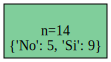

In [44]:
arbol = Tree()
arbol.fit(X, y)
print(arbol)
arbol.render()

Para evaluar instancias en el árbol podemos construirlas y evaluarlas de la siguiente manera:

In [45]:
xs_nuevo = [{'Cielo': 'Sol', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'},
            {'Cielo': 'Nublado', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'}]

for instancia in xs_nuevo:
    res = arbol.predict(instancia)
    print(f"Para un día {instancia} obtuve {res}")

Para un día {'Cielo': 'Sol', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'} obtuve Si
Para un día {'Cielo': 'Nublado', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'} obtuve Si


¿Se obtuvieron los valores esperados? Explorar al menos 1 caso por cada rama del árbol.